<a href="https://colab.research.google.com/github/SBoo9/Indian-Army-Uniform-Classifier/blob/main/Indian_ArmyUniform_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fot this project I am using a dataset which I have shared in my drive the given dataset is in form of .tfrecord so firstly we would be extracting Images out of it.

In [1]:
import tensorflow as tf

In [2]:
def inspect_tfrecord(tfrecord_path, num_samples=1):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    for raw_record in raw_dataset.take(num_samples):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

# Example usage:
inspect_tfrecord("/content/drive/MyDrive/datasets/CRPF/train/Soldier_Detection.tfrecord")

features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
        value: "1"
        value: "1"
        value: "1"
        value: "1"
        value: "1"
        value: "1"
        value: "1"
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
        value: 2
        value: 2
        value: 2
        value: 2
        value: 2
        value: 2
        value: 2
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
        value: 0.135937497
        value: 0.170312494
        value: 0.175
        value: 0.165625
        value: 0.225
        value: 0.192187503
        value: 0.129687503
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list {
        value: 1
        value: 0.970312476
        value: 0.9625
        value: 0.903125
     

From here we are able to get an understanding about the dataset we are going to handle

In [3]:
import tensorflow as tf
import os

def extract_images_to_class_folders(tfrecord_path, base_output_dir):
    """
    Extracts images from a TFRecord file and saves them into subfolders
    based on their class labels.

    Args:
        tfrecord_path (str): Path to the TFRecord file.
        base_output_dir (str): The base directory where class-specific subfolders will be created.
    """

    # Create the base output directory if it doesn't exist
    if not os.path.exists(base_output_dir):
        os.makedirs(base_output_dir)
        print(f"Created base output directory: {base_output_dir}")

    # Define the TFRecord parsing function
    def _parse_function(example_proto):
        feature_description = {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/format': tf.io.FixedLenFeature([], tf.string),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/object/class/text': tf.io.VarLenFeature(tf.string), # This is where your class names are
        }
        return tf.io.parse_single_example(example_proto, feature_description)

    # Create a TFRecord dataset
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_dataset = raw_dataset.map(_parse_function)

    print(f"Starting image extraction from: {tfrecord_path}")

    # Keep track of counts per class
    class_image_counts = {}

    for i, parsed_record in enumerate(parsed_dataset):
        try:
            image_bytes = parsed_record['image/encoded'].numpy()
            image_format = parsed_record['image/format'].numpy().decode('utf-8')

            # Extract the class label
            # Assuming 'image/object/class/text' contains at least one class label
            # If multiple labels, this will take the first one. Adjust if different logic is needed.
            class_labels = [label.decode('utf-8') for label in parsed_record['image/object/class/text'].values.numpy()]

            if not class_labels:
                print(f"Warning: No class label found for record {i}. Skipping image.")
                continue

            # Use the first class label found for subfolder creation
            class_name = class_labels[0]

            # Determine image extension (e.g., 'jpeg', 'png')
            extension = image_format.split('/')[-1] if '/' in image_format else image_format

            # Create class-specific subfolder
            class_output_dir = os.path.join(base_output_dir, class_name)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)
                print(f"Created class directory: {class_output_dir}")

            # Update count for the current class
            class_image_counts[class_name] = class_image_counts.get(class_name, 0) + 1

            # Generate a unique filename for each image within its class folder
            image_filename = os.path.join(class_output_dir, f"{class_name}_{class_image_counts[class_name]:05d}.{extension}")

            # Save the image bytes to a file
            with open(image_filename, 'wb') as f:
                f.write(image_bytes)

            if (sum(class_image_counts.values())) % 100 == 0:
                print(f"Extracted {sum(class_image_counts.values())} images so far...")

        except Exception as e:
            print(f"Error processing record {i}: {e}")
            continue

    print(f"Finished extraction. Total images extracted per class: {class_image_counts} to {base_output_dir}")

# --- How to use the function ---
if __name__ == '__main__':
    # Replace 'your_tfrecord_file.tfrecord' with the actual path to your TFRecord file
    # And 'categorized_images' with your desired base output folder name
    tfrecord_file = '/content/drive/MyDrive/datasets/CRPF/train/Soldier_Detection.tfrecord'
    base_output_folder = '/content/dataset/'

    # Create a dummy TFRecord file for demonstration if it doesn't exist
    if not os.path.exists(tfrecord_file):
        print(f"Creating a dummy TFRecord file '{tfrecord_file}' for demonstration...")

        # Example image data (a very small black square for demonstration)
        dummy_image_data_bsf = tf.image.encode_jpeg(tf.zeros([20, 20, 3], dtype=tf.uint8)).numpy()
        dummy_image_data_no_bsf = tf.image.encode_jpeg(tf.ones([20, 20, 3], dtype=tf.uint8) * 255).numpy() # White square

        with tf.io.TFRecordWriter(tfrecord_file) as writer:
            # Write some BSF images
            for i in range(5):
                feature_bsf = {
                    'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[dummy_image_data_bsf])),
                    'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpeg'])),
                    'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[20])),
                    'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[20])),
                    'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'BSF'])),
                }
                example_bsf = tf.train.Example(features=tf.train.Features(feature=feature_bsf))
                writer.write(example_bsf.SerializeToString())

            # Write some no_BSF images
            for i in range(3):
                feature_no_bsf = {
                    'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[dummy_image_data_no_bsf])),
                    'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpeg'])),
                    'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[20])),
                    'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[20])),
                    'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'no_BSF'])),
                }
                example_no_bsf = tf.train.Example(features=tf.train.Features(feature=feature_no_bsf))
                writer.write(example_no_bsf.SerializeToString())
        print("Dummy TFRecord file created.")

    extract_images_to_class_folders(tfrecord_file, base_output_folder)

Created base output directory: /content/dataset/
Starting image extraction from: /content/drive/MyDrive/datasets/CRPF/train/Soldier_Detection.tfrecord
Created class directory: /content/dataset/1
Created class directory: /content/dataset/2
Created class directory: /content/dataset/0
Extracted 100 images so far...
Finished extraction. Total images extracted per class: {'1': 36, '2': 36, '0': 33} to /content/dataset/


Now we get dataset of 3 classes 0-BSF, 1-CRPF, 2-Police. We will further work extracting more data from our current dataset. If anytime you require to download the dataset you may use the command below, also rename the folders into cateogeries.

T

In [ ]:
# Compress the /content/dataset folder into a zip file
!zip -r /content/dataset.zip /content/dataset

# Download the zip file to your local machine
from google.colab import files
files.download('/content/dataset.zip')

Developing cropped Images for further experimentation

In [4]:
# Install required packages
!pip install ultralytics opencv-python pillow matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
import os
import cv2
import shutil
from ultralytics import YOLO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [156]:
# Configure your dataset paths
ORIGINAL_DATASET_PATH = "/content/dataset"  # Change this to your dataset path
CROPPED_DATASET_PATH = "/content/cropped_dataset"  # Output directory for cropped images
CLASS_NAMES = ['BSF', 'CRPF', 'JnK']  # Your class names

# Display current configuration
print("📋 DATASET CONFIGURATION")
print("="*50)
print(f"Original dataset path: {ORIGINAL_DATASET_PATH}")
print(f"Cropped output path: {CROPPED_DATASET_PATH}")
print(f"Classes: {CLASS_NAMES}")

📋 DATASET CONFIGURATION
Original dataset path: /content/dataset
Cropped output path: /content/cropped_dataset
Classes: ['BSF', 'CRPF', 'JnK']


In [157]:

def load_yolo_model():
    """Load YOLOv8 model for person detection"""
    print("🤖 Loading YOLOv8n model...")
    try:
        yolo_model = YOLO('yolov8n.pt')
        print("✅ YOLOv8n model loaded successfully!")
        return yolo_model
    except Exception as e:
        print(f"❌ Error loading YOLOv8n model: {e}")
        return None

# Load the model
yolo_model = load_yolo_model()

🤖 Loading YOLOv8n model...
✅ YOLOv8n model loaded successfully!


In [158]:
# Analyze original dataset structure
def analyze_original_dataset(data_dir, class_names):
    """Analyze the original dataset structure"""
    print("📊 ORIGINAL DATASET ANALYSIS")
    print("="*50)

    if not os.path.exists(data_dir):
        print(f"❌ Dataset directory not found: {data_dir}")
        return {}

    class_counts = {}
    total_images = 0

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            class_counts[class_name] = len(image_files)
            total_images += len(image_files)

            print(f"  {class_name}: {len(image_files)} images")
            if len(image_files) > 0:
                print(f"    Sample files: {image_files[:3]}")
        else:
            print(f"  ⚠️  {class_name}: folder not found!")
            class_counts[class_name] = 0

    print(f"\nTotal images: {total_images}")
    if len(class_names) > 0:
        print(f"Average per class: {total_images/len(class_names):.1f}")

    return class_counts

# Analyze original dataset
original_counts = analyze_original_dataset(ORIGINAL_DATASET_PATH, CLASS_NAMES)

📊 ORIGINAL DATASET ANALYSIS
  BSF: 33 images
    Sample files: ['0_00012.jpeg', '0_00020.jpeg', '0_00021.jpeg']
  CRPF: 36 images
    Sample files: ['1_00019.jpeg', '1_00008.jpeg', '1_00036.jpeg']
  JnK: 32 images
    Sample files: ['2_00027.jpeg', '2_00003.jpeg', '2_00017.jpeg']

Total images: 101
Average per class: 33.7


In [159]:
# Create output directory structure
def setup_output_directory(output_dir, class_names):
    """Setup output directory for cropped images"""
    print(f"📁 Setting up output directory: {output_dir}")

    # Clear existing directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        print(f"  Cleared existing directory")

    # Create main directory
    os.makedirs(output_dir)

    # Create class subdirectories
    for class_name in class_names:
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        print(f"  Created: {class_dir}")

    print("✅ Output directory setup complete!")

# Setup output directory
setup_output_directory(CROPPED_DATASET_PATH, CLASS_NAMES)

📁 Setting up output directory: /content/cropped_dataset
  Cleared existing directory
  Created: /content/cropped_dataset/BSF
  Created: /content/cropped_dataset/CRPF
  Created: /content/cropped_dataset/JnK
✅ Output directory setup complete!


In [160]:
# Define the main cropping function
def detect_and_crop_soldiers(yolo_model, input_dir, output_dir, class_names, confidence_threshold=0.5):
    """
    Detect and crop soldiers from images

    Args:
        yolo_model: Loaded YOLO model
        input_dir: Input directory with class folders
        output_dir: Output directory for cropped images
        class_names: List of class names
        confidence_threshold: Minimum confidence for detection
    """
    print(f"🔍 DETECTING AND CROPPING SOLDIERS")
    print(f"Confidence threshold: {confidence_threshold}")
    print("="*50)

    if yolo_model is None:
        print("❌ YOLO model not loaded!")
        return {}

    total_cropped = 0
    class_results = {}

    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.exists(class_path):
            print(f"⚠️  Class folder not found: {class_path}")
            class_results[class_name] = 0
            continue

        # Get image files
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

        print(f"\n📁 Processing {class_name}: {len(image_files)} images")

        cropped_count = 0

        for i, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)

            try:
                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"  ⚠️  Could not read: {img_file}")
                    continue

                # Run YOLO detection
                results = yolo_model.predict(img, conf=confidence_threshold, verbose=False)

                # Process detections
                person_count = 0
                for result in results:
                    for box in result.boxes:
                        # Check if detection is a person
                        if yolo_model.names[int(box.cls[0])] == 'person':
                            # Get bounding box
                            x1, y1, x2, y2 = map(int, box.xyxy[0])
                            confidence = float(box.conf[0])

                            # Crop the person
                            cropped_img = img[y1:y2, x1:x2]

                            # Validate crop
                            if cropped_img.shape[0] > 0 and cropped_img.shape[1] > 0:
                                # Create filename
                                base_name = os.path.splitext(img_file)[0]
                                output_filename = f"cropped_{base_name}_p{person_count}_c{confidence:.2f}.jpg"
                                output_path = os.path.join(output_dir, class_name, output_filename)

                                # Save cropped image
                                cv2.imwrite(output_path, cropped_img)
                                person_count += 1
                                cropped_count += 1

                # Show progress
                if (i + 1) % 10 == 0:
                    print(f"  Progress: {i+1}/{len(image_files)} images processed")

            except Exception as e:
                print(f"  ❌ Error processing {img_file}: {e}")
                continue

        class_results[class_name] = cropped_count
        total_cropped += cropped_count
        print(f"  ✅ {class_name}: {cropped_count} soldiers cropped")

    print(f"\n🎉 CROPPING COMPLETE!")
    print(f"Total soldiers cropped: {total_cropped}")

    return class_results

# This cell only defines the function, execution is in the next cell

In [161]:
# Execute the cropping process
print("🚀 STARTING CROPPING PROCESS")
print("="*50)

# Run cropping
cropping_results = detect_and_crop_soldiers(
    yolo_model=yolo_model,
    input_dir=ORIGINAL_DATASET_PATH,
    output_dir=CROPPED_DATASET_PATH,
    class_names=CLASS_NAMES,
    confidence_threshold=0.5
)

# Display results
print("\n📈 CROPPING RESULTS:")
for class_name, count in cropping_results.items():
    print(f"  {class_name}: {count} soldiers cropped")

🚀 STARTING CROPPING PROCESS
🔍 DETECTING AND CROPPING SOLDIERS
Confidence threshold: 0.5

📁 Processing BSF: 33 images
  Progress: 10/33 images processed
  Progress: 20/33 images processed
  Progress: 30/33 images processed
  ✅ BSF: 82 soldiers cropped

📁 Processing CRPF: 36 images
  Progress: 10/36 images processed
  Progress: 20/36 images processed
  Progress: 30/36 images processed
  ✅ CRPF: 87 soldiers cropped

📁 Processing JnK: 32 images
  Progress: 10/32 images processed
  Progress: 20/32 images processed
  Progress: 30/32 images processed
  ✅ JnK: 100 soldiers cropped

🎉 CROPPING COMPLETE!
Total soldiers cropped: 269

📈 CROPPING RESULTS:
  BSF: 82 soldiers cropped
  CRPF: 87 soldiers cropped
  JnK: 100 soldiers cropped


To download the new dataset please refer to the function provided at the start.

In [162]:
# Analyze the cropped dataset
def analyze_cropped_dataset(cropped_dir, class_names):
    """Analyze the cropped dataset"""
    print("📊 CROPPED DATASET ANALYSIS")
    print("="*50)

    if not os.path.exists(cropped_dir):
        print(f"❌ Cropped dataset not found: {cropped_dir}")
        return {}

    class_counts = {}
    total_images = 0

    for class_name in class_names:
        class_path = os.path.join(cropped_dir, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            class_counts[class_name] = len(image_files)
            total_images += len(image_files)

            print(f"  {class_name}: {len(image_files)} cropped images")
            if len(image_files) > 0:
                print(f"    Sample: {image_files[:2]}")
        else:
            print(f"  ⚠️  {class_name}: folder not found")
            class_counts[class_name] = 0

    print(f"\nTotal cropped images: {total_images}")
    if len(class_names) > 0:
        print(f"Average per class: {total_images/len(class_names):.1f}")

        # Check class balance
        if total_images > 0:
            max_count = max(class_counts.values())
            min_count = min([c for c in class_counts.values() if c > 0])
            if min_count > 0:
                balance_ratio = max_count / min_count
                print(f"Class balance ratio: {balance_ratio:.2f}")
                if balance_ratio > 3:
                    print("⚠️  Dataset is imbalanced!")

    return class_counts

# Analyze cropped dataset
cropped_counts = analyze_cropped_dataset(CROPPED_DATASET_PATH, CLASS_NAMES)

📊 CROPPED DATASET ANALYSIS
  BSF: 82 cropped images
    Sample: ['cropped_0_00001_p0_c0.86.jpg', 'cropped_0_00003_p0_c0.78.jpg']
  CRPF: 87 cropped images
    Sample: ['cropped_1_00018_p1_c0.86.jpg', 'cropped_1_00035_p1_c0.82.jpg']
  JnK: 100 cropped images
    Sample: ['cropped_2_00012_p5_c0.72.jpg', 'cropped_2_00006_p1_c0.85.jpg']

Total cropped images: 269
Average per class: 89.7
Class balance ratio: 1.22


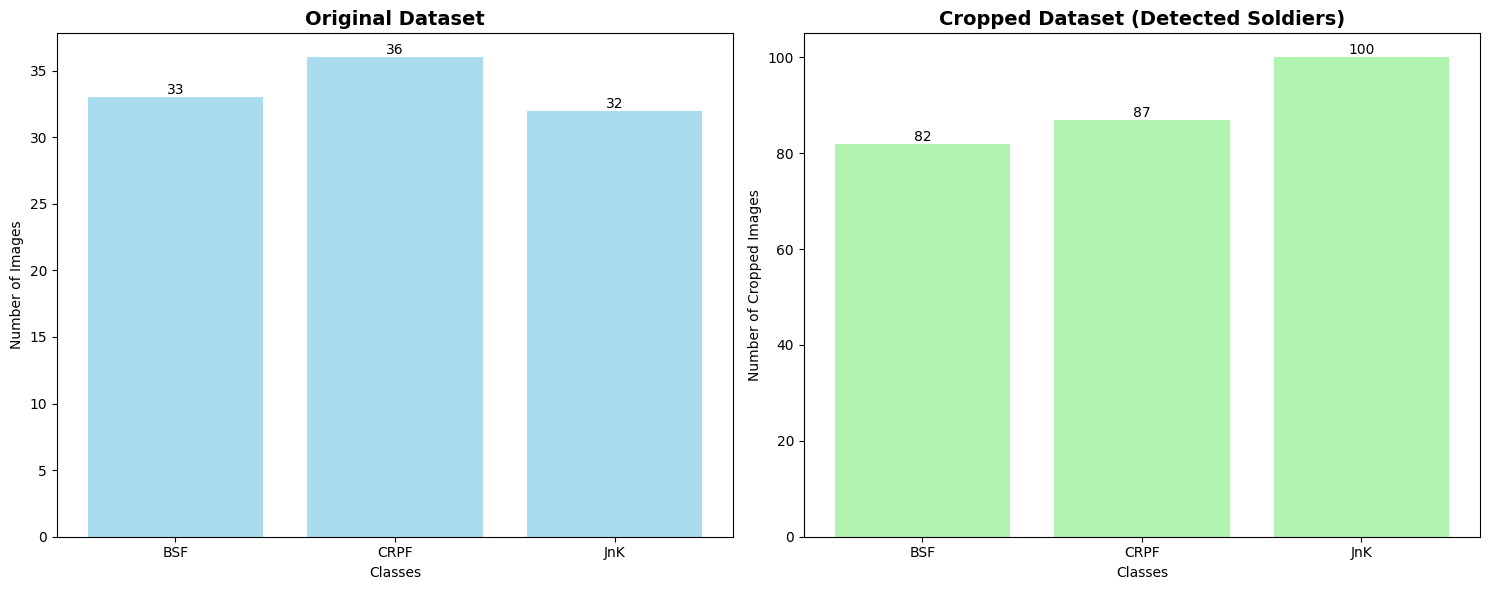

📈 DATASET COMPARISON SUMMARY:
Original total images: 101
Cropped total images: 269
Detection rate: 266.3%

Per-class detection rates:
  BSF: 248.5%
  CRPF: 241.7%
  JnK: 312.5%


In [163]:
# Create visualization comparing original vs cropped datasets
def plot_dataset_comparison(original_counts, cropped_counts, class_names):
    """Plot comparison between original and cropped datasets"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original dataset
    original_values = [original_counts.get(class_name, 0) for class_name in class_names]
    bars1 = ax1.bar(class_names, original_values, color='skyblue', alpha=0.7)
    ax1.set_title('Original Dataset', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images')
    ax1.set_xlabel('Classes')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    # Cropped dataset
    cropped_values = [cropped_counts.get(class_name, 0) for class_name in class_names]
    bars2 = ax2.bar(class_names, cropped_values, color='lightgreen', alpha=0.7)
    ax2.set_title('Cropped Dataset (Detected Soldiers)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Cropped Images')
    ax2.set_xlabel('Classes')

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("📈 DATASET COMPARISON SUMMARY:")
    print("="*50)
    total_original = sum(original_values)
    total_cropped = sum(cropped_values)

    print(f"Original total images: {total_original}")
    print(f"Cropped total images: {total_cropped}")

    if total_original > 0:
        detection_rate = (total_cropped / total_original) * 100
        print(f"Detection rate: {detection_rate:.1f}%")

    print(f"\nPer-class detection rates:")
    for i, class_name in enumerate(class_names):
        if original_values[i] > 0:
            rate = (cropped_values[i] / original_values[i]) * 100
            print(f"  {class_name}: {rate:.1f}%")

# Plot comparison
plot_dataset_comparison(original_counts, cropped_counts, CLASS_NAMES)

👀 PREVIEW OF CROPPED IMAGES
BSF: 82 images available
CRPF: 87 images available
JnK: 100 images available


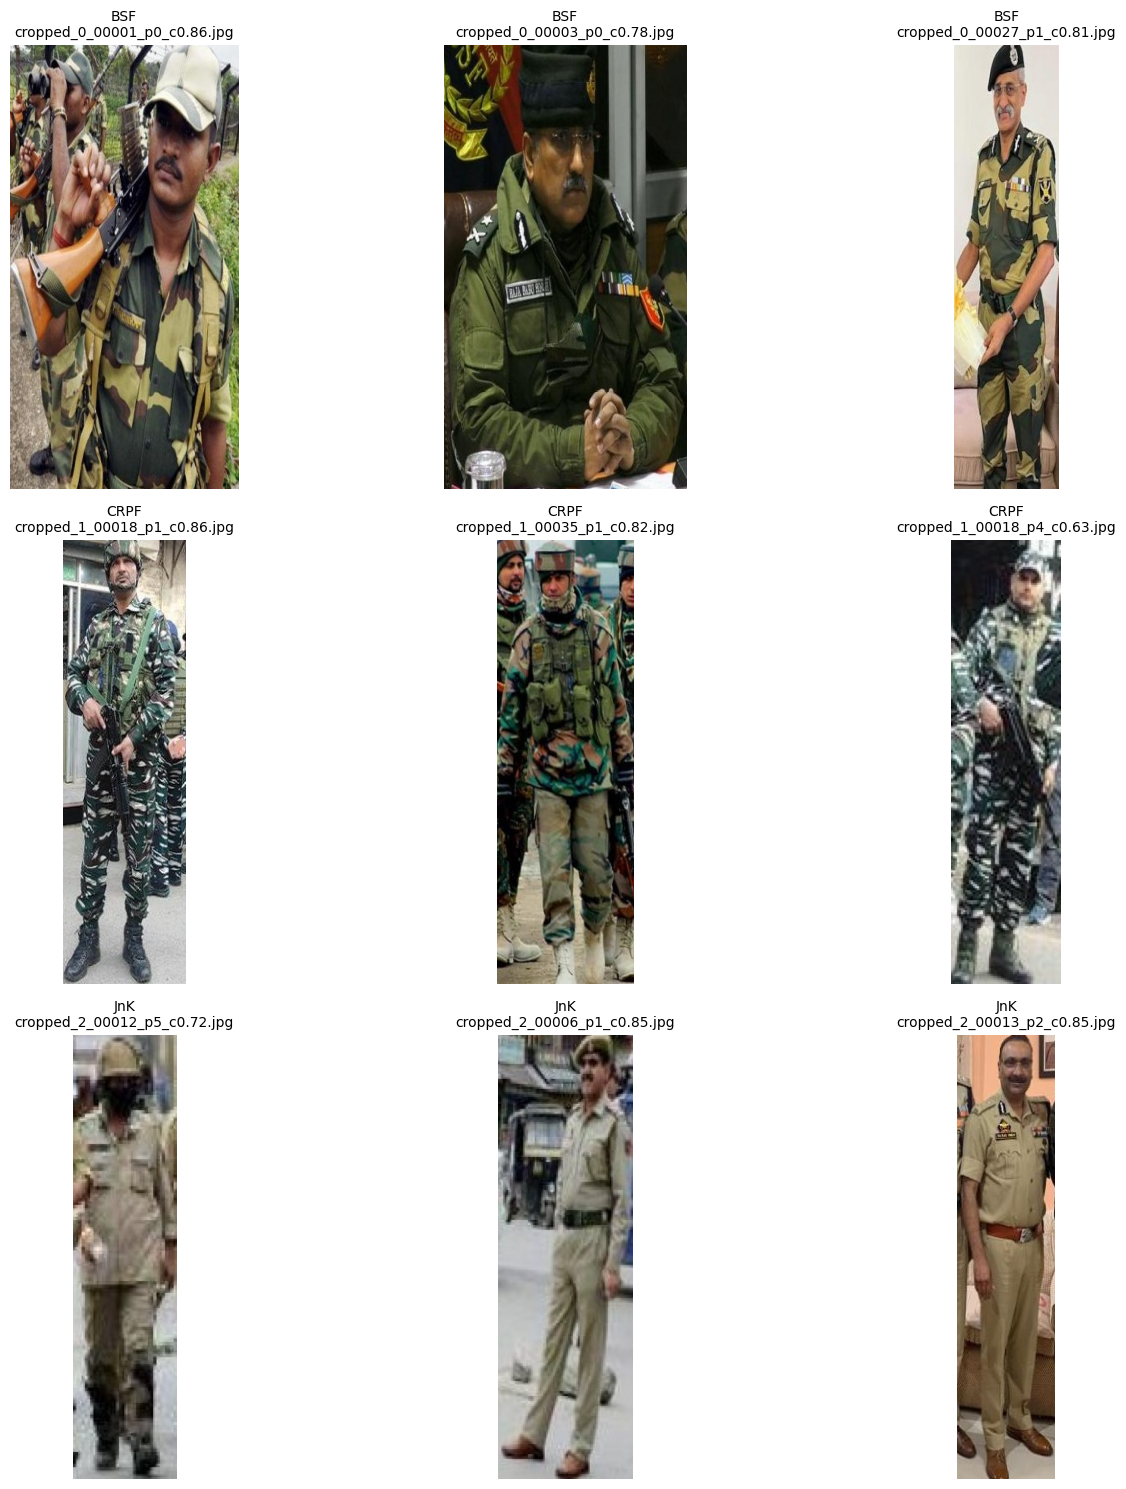

In [164]:
# Preview cropped images from each class
def preview_cropped_images(cropped_dir, class_names, num_samples=3):
    """Preview cropped images from each class"""

    print("👀 PREVIEW OF CROPPED IMAGES")
    print("="*50)

    fig, axes = plt.subplots(len(class_names), num_samples,
                            figsize=(15, 5*len(class_names)))

    if len(class_names) == 1:
        axes = axes.reshape(1, -1)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(cropped_dir, class_name)

        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

            print(f"{class_name}: {len(image_files)} images available")

            for j in range(min(num_samples, len(image_files))):
                img_path = os.path.join(class_path, image_files[j])
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        axes[i, j].imshow(img_rgb)
                        axes[i, j].set_title(f"{class_name}\n{image_files[j]}", fontsize=10)
                        axes[i, j].axis('off')
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    axes[i, j].axis('off')

            # Clear empty subplots
            for j in range(len(image_files), num_samples):
                axes[i, j].axis('off')
        else:
            print(f"{class_name}: No images found")
            for j in range(num_samples):
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Preview images
preview_cropped_images(CROPPED_DATASET_PATH, CLASS_NAMES, num_samples=3)

Lets move forward developing the model to help us predict which armed force an uniformed officer belongs to.

In [135]:
import os
import random
import shutil
from pathlib import Path

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt

In [165]:
def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8):
    """Split dataset into train and val sets"""
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        random.shuffle(images)

        split_point = int(len(images) * split_ratio)
        train_images = images[:split_point]
        val_images = images[split_point:]

        # Create class folders in train and val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))



In [166]:
# Define paths
source_folder = '/content/cropped_dataset'
train_folder = '/content/train'
val_folder = '/content/val'

In [167]:
split_dataset(source_folder, train_folder, val_folder)

In [168]:
train_dir = '/content/train'
val_dir = '/content/val'

In [169]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [170]:
train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset = ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['BSF', 'CRPF', 'JnK']


In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 3 classes: BSF, CRPF, JnK
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [172]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [173]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch [1/15], Loss: 8.2495, Accuracy: 53.68%
Epoch [2/15], Loss: 3.1719, Accuracy: 89.12%
Epoch [3/15], Loss: 1.8631, Accuracy: 93.68%
Epoch [4/15], Loss: 1.3533, Accuracy: 94.74%
Epoch [5/15], Loss: 0.6071, Accuracy: 98.95%
Epoch [6/15], Loss: 0.5983, Accuracy: 98.60%
Epoch [7/15], Loss: 0.4069, Accuracy: 99.30%
Epoch [8/15], Loss: 0.2372, Accuracy: 100.00%
Epoch [9/15], Loss: 0.1251, Accuracy: 100.00%
Epoch [10/15], Loss: 0.1353, Accuracy: 99.65%
Epoch [11/15], Loss: 0.1399, Accuracy: 100.00%
Epoch [12/15], Loss: 0.1059, Accuracy: 100.00%
Epoch [13/15], Loss: 0.1188, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0641, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0611, Accuracy: 100.00%


In [174]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 99.00%


In [175]:
torch.save(model.state_dict(), "soldier_classifier.pth")


Building Interface so user can upload a photo and check the model out

In [31]:
import gradio as gr
from PIL import Image

# Load the saved model
model.eval()

# Prediction function
def predict(image):
    image = image.convert("RGB")
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class


In [32]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Soldier Image"),
    outputs=gr.Label(num_top_classes=3, label="Prediction"),
    title="Soldier Uniform Classifier",
    description="Upload a soldier image (BSF, CRPF, or JnK) to classify based on uniform"
)

interface.launch(share=True)  # share=True gives you a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0f1ae33a87f519a51b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


I do have another Image dataset for training result purpose lets use it to get our models results

In [176]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch

In [177]:
test_input_DATASET_PATH = '/content/drive/MyDrive/test_model'
test_DATASET_PATH = '/content/test'

In [178]:
setup_output_directory(test_DATASET_PATH, CLASS_NAMES)

📁 Setting up output directory: /content/test
  Cleared existing directory
  Created: /content/test/BSF
  Created: /content/test/CRPF
  Created: /content/test/JnK
✅ Output directory setup complete!


In [179]:
# Execute the cropping process
print("🚀 STARTING CROPPING PROCESS")
print("="*50)

# Run cropping
cropping_results = detect_and_crop_soldiers(
    yolo_model=yolo_model,
    input_dir=test_input_DATASET_PATH,
    output_dir=test_DATASET_PATH,
    class_names=CLASS_NAMES,
    confidence_threshold=0.5
)

# Display results
print("\n📈 CROPPING RESULTS:")
for class_name, count in cropping_results.items():
    print(f"  {class_name}: {count} soldiers cropped")

🚀 STARTING CROPPING PROCESS
🔍 DETECTING AND CROPPING SOLDIERS
Confidence threshold: 0.5

📁 Processing BSF: 4 images
  ✅ BSF: 14 soldiers cropped

📁 Processing CRPF: 3 images
  ✅ CRPF: 7 soldiers cropped

📁 Processing JnK: 3 images
  ✅ JnK: 9 soldiers cropped

🎉 CROPPING COMPLETE!
Total soldiers cropped: 30

📈 CROPPING RESULTS:
  BSF: 14 soldiers cropped
  CRPF: 7 soldiers cropped
  JnK: 9 soldiers cropped


In [180]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [181]:
test_dataset = datasets.ImageFolder('/content/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [182]:
class_names = test_dataset.classes
print(f"🧾 Test Classes: {class_names}")

🧾 Test Classes: ['BSF', 'CRPF', 'JnK']


In [183]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n🎯 Test Accuracy: {acc * 100:.2f}%")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\n🧮 Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [184]:
evaluate_model(model, test_loader, class_names)



🎯 Test Accuracy: 50.00%

📊 Classification Report:
              precision    recall  f1-score   support

         BSF       1.00      0.43      0.60        14
        CRPF       0.46      0.86      0.60         7
         JnK       0.27      0.33      0.30         9

    accuracy                           0.50        30
   macro avg       0.58      0.54      0.50        30
weighted avg       0.66      0.50      0.51        30


🧮 Confusion Matrix:
[[6 1 7]
 [0 6 1]
 [0 6 3]]
